## Imports

In [12]:
import numpy as np
import cupy as cp
from matplotlib import pyplot as plt, transforms
import random
import pandas as pd
# from Load_Recording_Data import LoadRecordingData, Recording           # (Use this for old data)
from load_recording_data import LoadRecordingData#, Recording            # (Use this for new data)
import scipy
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso
import pysindy as ps
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.integrate import quad
import tensorflow as tf
import keras
from fastdtw import fastdtw
import itertools
import copy

In [13]:
gpus = tf.config.list_physical_devices('GPU')
gpu_id = 3
tf.config.set_visible_devices(gpus[gpu_id], 'GPU')

## Load Data

In [14]:
# intrasTrain, extrasTrain, intrasTest, extrasTest = LoadRecordingData()
intrasTrainVal, extrasTrainVal, intrasTest, extrasTest = LoadRecordingData()
idx_train, idx_val = train_test_split(np.arange(len(intrasTrainVal)), test_size=0.20)#, random_state=42)

extrasTrain = extrasTrainVal[idx_train]
intrasTrain = intrasTrainVal[idx_train]
extrasVal = extrasTrainVal[idx_val]
intrasVal = intrasTrainVal[idx_val]

# dataset = LoadRecordingData()
# idx_train, idx_test = train_test_split(np.arange(len(intrasRaw)), test_size=0.25, random_state=42)

# extrasTrain = dataset['8k'].extras_training2
# intrasTrain = dataset['8k'].intras_training2
# extrasVal = dataset['8k'].extras_val2
# intrasVal = dataset['8k'].intras_val2

W5FebD1_10nM_Dofe_51_52_8000
W5FebD1_10nM_Dofe_57_58_8000
W5FebD1_10nM_Dofe_84_85_8000
W8FebD2_10nM_Dofe_57_47_8000
W8FebD2_10nM_Dofe_84_74_8000
W8FebD3_10nM_Dofe_24_14_8000
W8FebD3_10nM_Dofe_61_62_8000


## Helper functions

In [15]:
# Takes in a 1-dimensional array and a window size, and applies a moving
# average filter to data.
def moving_filter(data, window_size):
    i = 0
    moving_averages = []
    while i < len(data) - window_size + 1:
        this_window = data[i : i + window_size]

        window_average = sum(this_window) / window_size
        moving_averages.append(window_average)
        i += 1

    for i in range(window_size - 1):
        ind = len(data) - (window_size - i)
        moving_averages.append(np.mean(data[ind-window_size:ind]))

    return moving_averages

def mse(y, p):
    return np.mean((y-p)**2)

def mae(y, p):
    return np.mean(np.absolute(y-p))

def dtw(y, p):
    distances = []
    
    for i in range(len(y)):
        dist, _ = fastdtw(y[i], p[i])
        distances.append(dist)
        
    return np.mean(np.array(distances))

def sigmoid(x):
    return 1/(1 + np.exp(-x))

def ScaleMaxTo1(arr):
    arrMin = np.min(arr, axis=-1, keepdims=True)
    arrMax = np.max(arr, axis=-1, keepdims=True)
    return ((arr - arrMin)*(1 - arrMin))/(arrMax - arrMin) + arrMin

### Smooth the data by applying moving filter

In [16]:
# Apply moving filter on intras and extras
# Training set
windowSize = 20
temp = []

for rec in intrasTrain:
    temp.append(moving_filter(rec, windowSize))
    
intrasTrain = np.array(temp)

temp = []

for rec in extrasTrain:
    smooth = moving_filter(rec, windowSize)
#     smooth[np.argmax(rec)] = np.max(rec)
#     smooth[np.argmin(rec)] = np.min(rec)
    temp.append(smooth)
    
extrasTrain = np.array(temp)

# Validation set
temp = []

for rec in intrasVal:
    temp.append(moving_filter(rec, windowSize))
    
intrasVal = np.array(temp)

temp = []

for rec in extrasVal:
    smooth = moving_filter(rec, windowSize)
#     smooth[np.argmax(rec)] = np.max(rec)
#     smooth[np.argmin(rec)] = np.min(rec)
    temp.append(smooth)
    
extrasVal = np.array(temp)


# Test set
temp = []

for rec in intrasTest:
    temp.append(moving_filter(rec, windowSize))
    
intrasTest = np.array(temp)

temp = []

for rec in extrasTest:
    smooth = moving_filter(rec, windowSize)
#     smooth[np.argmax(rec)] = np.max(rec)
#     smooth[np.argmin(rec)] = np.min(rec)
    temp.append(smooth)
    
extrasTest = np.array(temp)

### Function to extract features

In [17]:
def GetFeatures(intras, extras):
    X = []
    Y = []
    windowSize = 20
    
#     featureNames = ['d2eAP', 'deAP', 'eAP', 'exp(d2eAP)', 'exp(deAP)', 'exp(eAP)']#, 'distFromMax', 'distFromMin']
#     s = [i for i in range(len(featureNames))]
#     combs = [list(itertools.combinations(s, r)) for r in range(len(s)+1)]
#     featureCombs = []
    
#     for comb in combs[1:]:
#         for tpl in comb:
#             name = ""

#             for ind in tpl:
#                 name += "*"+featureNames[ind]

#             featureCombs.append(name)

    
    t = np.array([i for i in range(len(extras[0]))])/len(extras[0])
    
    for i in range(len(extras)):
        iAP = intras[i]
        diAP = np.array(moving_filter(np.gradient(iAP), windowSize))
        d2iAP = np.array(moving_filter(np.gradient(np.gradient(iAP)), windowSize))

        eAP = extras[i]
        deAP = np.array(moving_filter(np.gradient(eAP), windowSize))
        d2eAP = np.array(moving_filter(np.gradient(deAP), windowSize))
            
#         iAP = intras[i]
#         diAP = np.gradient(iAP)
#         d2iAP = np.gradient(diAP)

#         eAP = extras[i]
#         deAP = np.gradient(eAP)
#         d2eAP = np.gradient(deAP)


        featureMatrix = [d2eAP, deAP, eAP, t]#, np.exp(d2eAP), np.exp(deAP), np.exp(eAP)]
#         featureList = [d2eAP, deAP, eAP, np.exp(d2eAP), np.exp(deAP), np.exp(eAP)]
    

#         maxInd = np.argmax(eAP[:1500])
#         minInd = 1500 + np.argmin(eAP[1500:])

#         distFromMax = [i for i in range(len(extras[0]))]
#         distFromMin = [i for i in range(len(extras[0]))]

#         distFromMax = np.exp(-np.absolute(distFromMax - maxInd))
#         distFromMin = np.exp(-np.absolute((distFromMin - minInd)/50))

#         featureList.append(distFromMax)
#         featureList.append(distFromMin)
            
#         featureMatrix = []
        
#         for comb in combs[1:]:
#             for tpl in comb:
#                 feature = 1
                
#                 for ind in tpl:
#                     feature = feature*featureList[ind]
                    
#                 featureMatrix.append(feature)
        
        X.append(np.array(featureMatrix).T)
        Y.append(iAP)
        
#     X = np.array(X)
#     Y = np.array(Y)
     
    return X, Y

### Extract features from train, val and test data

In [18]:
X0, Y0 = GetFeatures(intrasTrain, extrasTrain)

In [19]:
X_val0, Y_val0 = GetFeatures(intrasVal, extrasVal)

In [20]:
X_test0, Y_test0 = GetFeatures(intrasTest, extrasTest)

## SINDy model

In [21]:
differentiation_method = ps.FiniteDifference(order=3)

feature_library = ps.PolynomialLibrary(degree=2)
#feature_library = ps.FourierLibrary(n_frequencies=5)

library_functions = [
    lambda x: np.exp(x),
#     lambda x: 1.0 / (1 + x),
#     lambda x: x,
#     lambda x, y: np.sin(x + y),
]

library_function_names = [
    lambda x: "exp(" + x + ")",
#     lambda x: "1/(1 + " + x + ")",
#     lambda x: x,
#     lambda x, y: "sin(" + x + "," + y + ")",
]

custom_library = ps.CustomLibrary(
    library_functions=library_functions, function_names=library_function_names
)

generalized_library = ps.GeneralizedLibrary([feature_library, custom_library])

# optimizer = ps.STLSQ(threshold=0.2, alpha=0.5)
optimizer = ps.SR3(threshold=0.1, thresholder="l2")
# optimizer = ps.SR3(trimming_fraction=0.1)
# optimizer = ps.SSR(alpha=0.05)
# optimizer = ps.SSR(alpha=0.05, criteria="model_residual")
# optimizer = ps.SSR(alpha=0.05, criteria="model_residual", kappa=1e-3)
# optimizer = ps.FROLS(alpha=0.05)
# optimizer = ps.FROLS(alpha=0.05, kappa=1e-7)
# optimizer = Lasso(alpha=0.000001)#, max_iter=2000)

discrete = False

model = copy.deepcopy(ps.SINDy(differentiation_method=differentiation_method,
    feature_library=generalized_library,
    optimizer=optimizer,
    discrete_time=discrete))

model.fit(X0, t=1, x_dot=Y0, multiple_trajectories=True)

model.print()

(x0)' = 243710975.272 1 + 243499409.073 x0 + 211934.233 x1 + 42.369 x2 + -27.047 x3 + 121352082.078 x0^2 + -69720.478 x0 x1 + -1299.375 x0 x2 + -1018.599 x0 x3 + 100832.816 x1^2 + -286.696 x1 x2 + -166.666 x1 x3 + 16.715 x2^2 + -4.852 x2 x3 + -31.400 x3^2 + -243499106.548 exp(x0) + -211863.950 exp(x1) + -39.294 exp(x2) + 34.275 exp(x3)


#### A small digression to experiment with predicting residuals in iAP (inspired by gradient boosting). Can be ignored for reproducing numbers

In [62]:
predD1 = np.array(model.predict(X0, multiple_trajectories=True))
predD1 = np.reshape(predD1, (predD1.shape[:2]))

# t = np.array([i for i in range(len(extrasTrain[0]))])/len(extrasTrain[0])
# predD1 = [np.array([x, t]).T for x in predD1]

model2 = copy.deepcopy(ps.SINDy(differentiation_method=differentiation_method,
    feature_library=generalized_library,
    optimizer=optimizer,
    discrete_time=discrete))


r = Y0 - predD1
model2.fit(X0, t=1, x_dot=[x for x in r], multiple_trajectories=True)

model2.print()

(x0)' = -79.594 1 + -79.548 x0 + -0.047 x1 + -39.752 x0^2 + -0.002 x0 x1 + -0.023 x1^2 + 79.548 exp(x0) + 0.047 exp(x1)


### Evaluate model on test data

In [22]:
# predD2 = np.array(model.predict(X_test0, multiple_trajectories=True))    
# predD2 = np.reshape(predD2, (predD2.shape[:2]))

# predD1 = np.array(model.predict(X_test0, multiple_trajectories=True))    
# predD1 = np.reshape(predD1, (predD1.shape[:2]))
# predD1 = np.cumsum(predD2, axis=1)

# res = np.array(model2.predict(X_test0, multiple_trajectories=True))
# res = np.reshape(res, res.shape[:2])

# predD1 += res
# predD1 = [np.array([x, t]).T for x in predD1]

pred = np.array(model.predict(X_test0, multiple_trajectories=True))
pred = np.reshape(pred, (pred.shape[:2]))
# pred = np.cumsum(predD1, axis=1)

# yd2 = np.array(Y_test0)
# yd1 = np.cumsum(yd2, axis=1)#np.array(Y_test0)
y = intrasTest#np.cumsum(yd1, axis=1)
# yiAP = np.cumsum(y, axis=1)

# print("MSE on test d1 with reg_selected", mse(predD1, yd1))
print("MSE on test d0 with reg_selected", mse(pred, y))
# print("MAE on test d1 with reg_selected", mae(predD1, yd1))
print("MAE on test d0 with reg_selected", mae(pred, y))
# print("DTW on test d1 with reg_selected", dtw(predD1, yd1))
print("DTW on test d0 with reg_selected", dtw(pred, y))

MSE on test d0 with reg_selected 0.020291184671896445
MAE on test d0 with reg_selected 0.09527631983425473
DTW on test d0 with reg_selected 261.314903120325


In [17]:
#311, 126, 280
import pickle
diAP_sindy = {}

### Prediction plots for a random recording from the test set

306


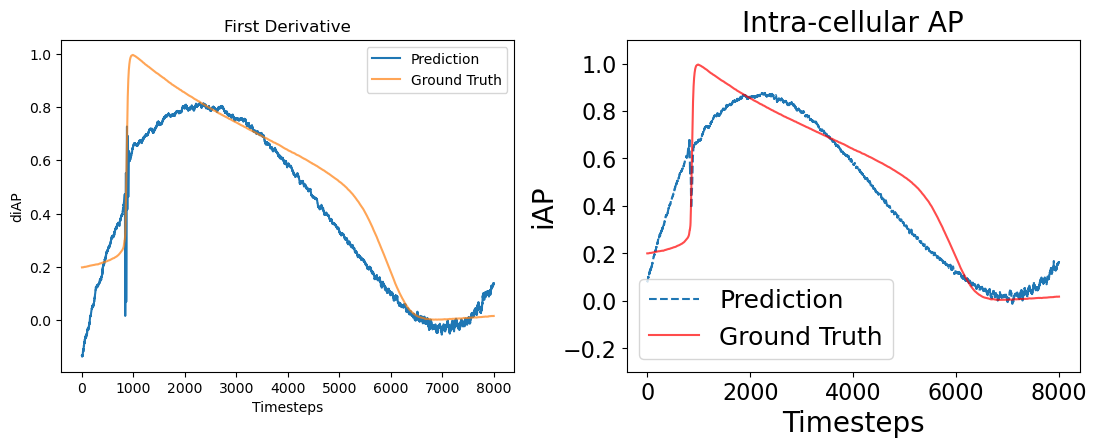

In [67]:
ind = random.randint(0, len(X0))#126, 311, 268, 280, 310 ---- 266, 283, 310, 186, 4 --- 319, 274
print(ind)
x, y = X0[ind], Y0[ind]

# predD2 = (model.predict(x)).reshape((-1))
# predD1 = np.cumsum(predD2)
# predD1 = (model.predict(x)).reshape((-1))
# predD1 = model2.predict(np.array([predD1, t]).T)
# predD1 = model3.predict(np.array([predD1, t]).T)

transparency = 0.7
fig0, ax0 = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
fig0.tight_layout(pad=5)

# Plot first derivative
ax0[0].plot(pred)
ax0[0].plot(y, alpha=transparency)
ax0[0].legend(['Prediction', 'Ground Truth'])
ax0[0].title.set_text("First Derivative")
ax0[0].set_xlabel("Timesteps")
ax0[0].set_ylabel("diAP")

# Plot iAP
pred = (model.predict(x)).reshape((-1))
# pred = np.cumsum(predD1)

# predMin = np.min(predIntegral, keepdims=True)
# predMax = np.max(predIntegral, keepdims=True)
# predIntegral = ((predIntegral-predMin)*(1 - predMin))/(predMax - predMin) + predMin

ax0[1].plot(pred, linestyle='dashed')
# ax0[1].plot(moving_filter(np.gradient(intrasTest[ind]), windowSize), alpha=transparency)
ax0[1].plot(intrasTrain[ind], alpha=transparency, color='red')
ax0[1].legend(['Prediction', 'Ground Truth'], prop={'size': 18})
ax0[1].title.set_text("Intra-cellular AP")
ax0[1].title.set_fontsize(20)
ax0[1].set_xlabel("Timesteps", fontsize=20)
ax0[1].set_ylabel("iAP", fontsize=20)
ax0[1].set_ylim([-0.3, 1.1])
ax0[1].tick_params(axis='x', labelsize=16)
ax0[1].tick_params(axis='y', labelsize=16)

In [65]:
diAP_sindy[280] = [pred, intrasTest[ind]]

NameError: name 'diAP_sindy' is not defined

In [24]:
diAP_sindy

{311: [AxesArray([ 0.00045381,  0.0009099 ,  0.00136852, ..., -0.17418053,
             -0.17415418, -0.17413184]),
  array([0.12428041, 0.12469824, 0.12483751, ..., 0.00389972, 0.00376045,
         0.00371402])],
 126: [AxesArray([ 4.97044389e-05,  1.20075939e-04,  1.92920064e-04, ...,
             -5.91884880e-02, -5.91789041e-02, -5.91623601e-02]),
  array([0.13106961, 0.13123939, 0.13123939, ..., 0.00622524, 0.00611205,
         0.00614035])],
 280: [AxesArray([0.00019457, 0.00037383, 0.0005404 , ..., 0.16585139,
             0.16604546, 0.16625737]),
  array([0.10603805, 0.10603805, 0.10595533, ..., 0.00339123, 0.00343259,
         0.00330852])]}